### This is PyTorch implementaion of the experiment described in the paper [The Mechanics of n-Player Differentiable Games](https://arxiv.org/abs/1802.05642)

The main goal of the following experiment is to answer the following questions regarding Symplectic Gradient Adjustment:

 - 1) Will it reduce mode collapse?
 - 2) Does it accelerate learning process and improve generator quality?
 
 Some hyperparameters and code for __x_real_gen__ I took [here](https://github.com/deepmind/symplectic-gradient-adjustment/blob/master/Symplectic_Gradient_Adjustment.ipynb)
 

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import urllib
import requests
from IPython.core.display import clear_output

from os import path
# нужна информация о нашей системе
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# уточним на чем будем вычислять
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
import torchvision
from torch import nn
print('torch version',torch.__version__)
print('torchvision version',torchvision.__version__)
print('is cuda availible',torch.cuda.is_available())

torch version 0.4.0
torchvision version 0.2.1
is cuda availible True


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd gdrive/My\ Drive/

/content/gdrive/My Drive


# 1. Without SGA

We will use just a simple GAN

In [0]:
from torch import nn

class MLP(nn.Module):
  
  def __init__(self, latent_dim, output_dim):
    
    super(MLP, self).__init__()
    
    self.latent_dim = latent_dim
    self.output_dim = output_dim
    self.hidden_dim = 384
    
    self.main = nn.Sequential(
                nn.Linear(self.latent_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.output_dim))

    def forward(self, inp):

        return self.main(inp)



In [0]:
def x_real_gen(batch_size):
    sigma = 0.1
    grid = np.array([
        [ 1.50,  1.50],
        [ 1.50,  0.50],
        [ 1.50, -0.50],
        [ 1.50, -1.50],
        [ 0.50,  1.50],
        [ 0.50,  0.50],
        [ 0.50, -0.50],
        [ 0.50, -1.50],
        [-1.50,  1.50],
        [-1.50,  0.50],
        [-1.50, -0.50],
        [-1.50, -1.50],
        [-0.50,  1.50],
        [-0.50,  0.50],
        [-0.50, -0.50],
        [-0.50, -1.50],
    ])
    
    temp = np.tile(grid, (batch_size // 16 + 1,1))
    mus = temp[0:batch_size,:]
    arr = mus + sigma*np.random.randn(batch_size, 2)
    return arr.astype(np.float32)

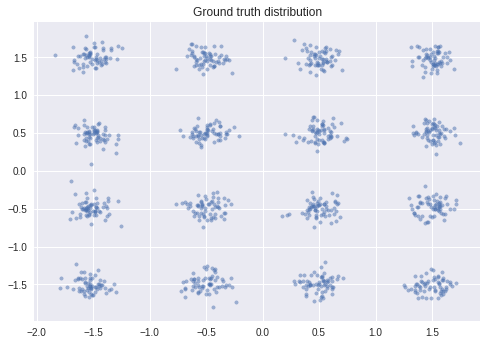

In [38]:
x = x_real_gen(1000)
plt.scatter(x[:,0], x[:,1], marker = '.', alpha = 0.5)
plt.title('Ground truth distribution')
plt.show()

## Now let's apply the original algorithm from [here](https://arxiv.org/abs/1406.2661) 

![](https://cdn-images-1.medium.com/max/800/1*WnsJz9ZKS3dV3Nw36RtefQ.png)

100%|██████████| 10000/10000 [04:00<00:00, 41.50it/s]


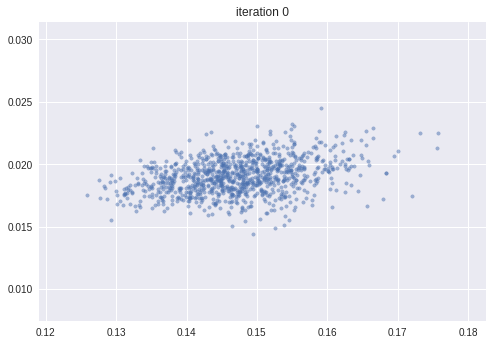

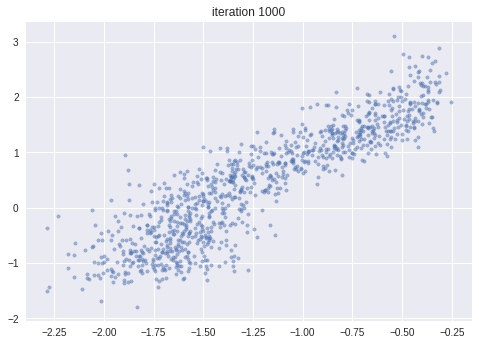

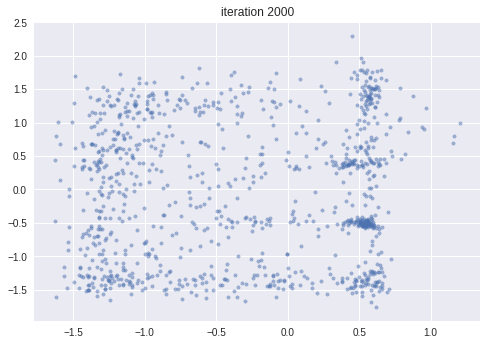

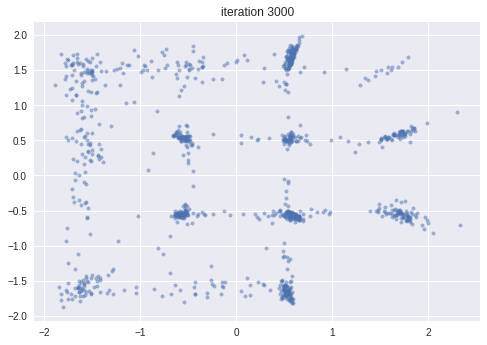

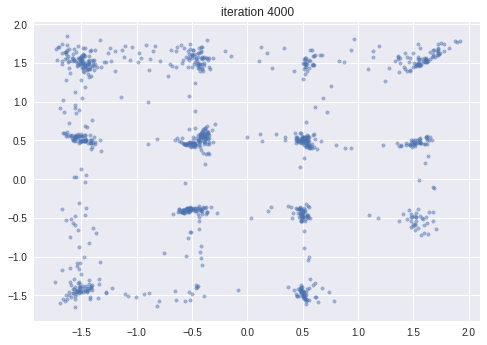

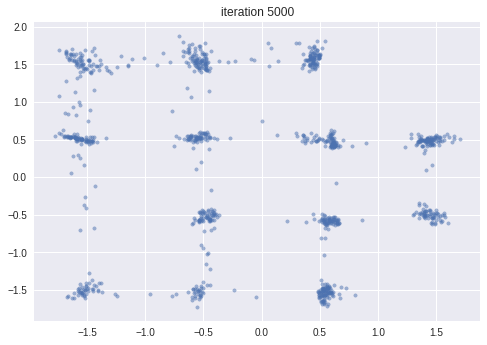

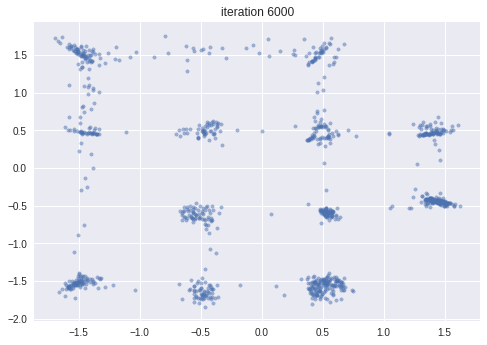

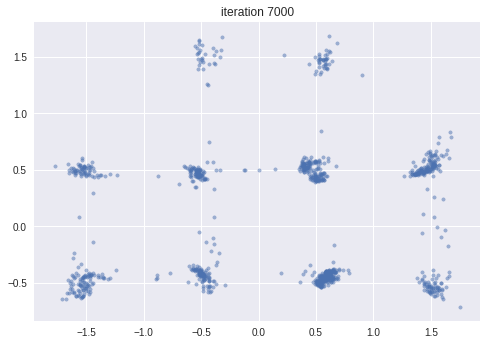

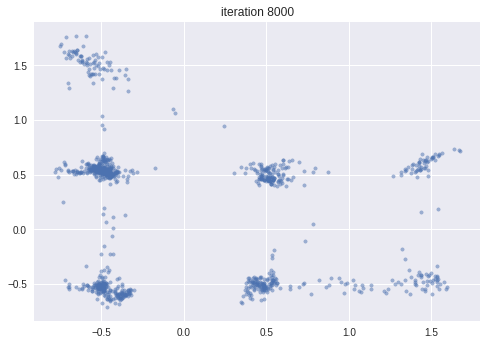

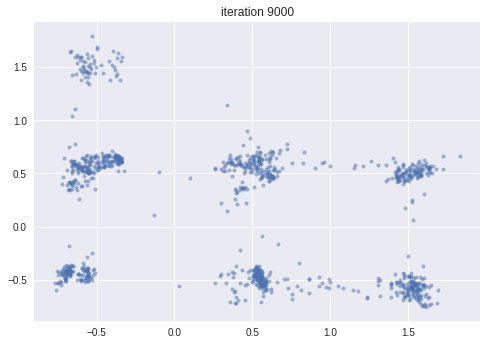

In [5]:
z_dim = 64

generator = MLP(z_dim, 2).cuda()
discriminator = MLP(2,1).cuda()

n_iter = int(1e+4)
batch_size = 300

disc_loss_hist = []
gen_loss_hist = []

lr_G = 2e-4
lr_D = 1e-4

optimizer_G = torch.optim.RMSprop(generator.parameters(), lr = lr_G)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr = lr_D)

loss = nn.BCEWithLogitsLoss()

k = 1

plot_freq = int(n_iter/10)

save = False  

# clean image store

if save:

    for fpath in os.listdir('./'):
        os.remove(fpath)
  
for it in tqdm(range(n_iter)):
  
    for i in range(k):
    
        discriminator.zero_grad()

        z = torch.randn([batch_size, z_dim]).cuda()
        x_fake = generator(z)
        x_real = torch.cuda.FloatTensor(x_real_gen(batch_size))
        disc_out_real = discriminator(x_real)
        disc_out_fake = discriminator(x_fake)

        # Loss
        disc_loss_real = loss(disc_out_real, torch.ones_like(disc_out_real).cuda())
        disc_loss_fake = loss(disc_out_fake, torch.zeros_like(disc_out_fake).cuda())

        disc_loss = disc_loss_real + disc_loss_fake
        disc_loss_hist += [disc_loss]

        disc_loss.backward()
        optimizer_D.step()
    
    generator.zero_grad() 

    z = torch.randn([batch_size, z_dim]).cuda()
    x_fake = generator(z)
    disc_out_fake = discriminator(x_fake)

    gen_loss = loss(disc_out_fake, torch.ones_like(disc_out_fake).cuda())
    gen_loss_hist += [gen_loss]

    gen_loss.backward()
    optimizer_G.step()
  
    if it%plot_freq == 0:

        n = 1000

        z = torch.randn([n, z_dim]).cuda()
        x_fake = generator(z).cpu().detach().numpy()

        plt.figure()
        plt.scatter(x_fake[:,0], x_fake[:,1], marker = '.', alpha = 0.5)
        plt.title('iteration {}'.format(it)) 
    
        if save:

            plt.savefig('./{}.png'.format(it))



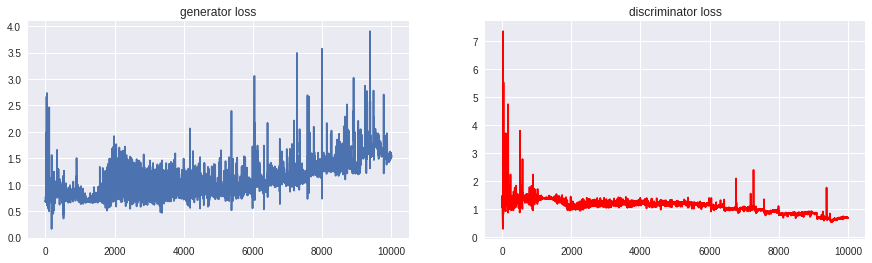

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (15,4))

ax1.plot(gen_loss_hist)
ax1.set_title('generator loss')
ax2.plot(disc_loss_hist, 'r')
ax2.set_title('discriminator loss')

plt.show()

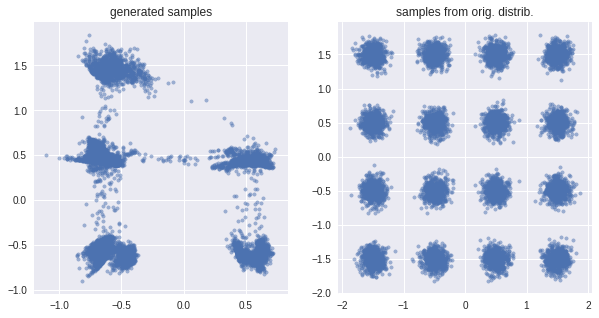

In [7]:
n = 10000

z = torch.randn([n, z_dim]).cuda()
x_fake = generator(z).cpu().detach().numpy()
x_real = x_real_gen(n)

fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (10,5))

ax1.scatter(x_fake[:,0], x_fake[:,1], marker = '.', alpha = 0.5)
ax1.set_title('generated samples')
ax2.scatter(x_real[:,0], x_real[:,1], marker = '.', alpha = 0.5)
ax2.set_title('samples from orig. distrib.')

plt.show()


Here we can observe partial mode collapse

# 1. With SGA

We will use just a simple GAN but with SGA binded with optimizer

Here is an algorithm of SGA from the paper:

![](https://cdn-ak.f.st-hatena.com/images/fotolife/t/toaruharunohi/20180926/20180926224437.png)

The main issue here is to compute the $A^{\top}$

There is the way to use code for TensorFlow provided in the paper:

![](https://pp.userapi.com/c849420/v849420634/e9b4f/H_NAC5PFY8M.jpg)

#### But it's not compatible with PyTorch. So below you can see my attempts to compute $A^{\top}\xi$ somehow else

$A$ may be computer explicitly using Helmholz decomposition. Since  $H = S + A$ where $H$ is a Hessian.

![](https://pp.userapi.com/c849420/v849420634/e9a3c/mGGPN-MAz1w.jpg)

$$ A^{\top} = \frac{1}{2}(H^{\top} - H)  $$


Since the whole Hessian $H$ doesn't fit the memory and it's not sparse I tried to compute $A^{\top}$ row by row by __get_At_row__  and multiply them by $\xi$ to obtain consecutive elements of $A^{\top}\xi$






In [0]:
def fill(x,w):
    
    '''
    Fill by zeros None positions in gradients
    '''

    new_x = []
  
    for i in range(len(x)):
    
        if type(x[i]) == type(None):
      
              new_x += [torch.zeros_like(w[i])]
      
        else:
      
          new_x += [x[i]]
      
    return new_x   


def flatten(tensor_seq):
    
    '''
    Returns flat torch.Tensor() from list of tensors 
    '''
    
    tens_flatten = tensor_seq[0].contiguous().view(-1)

    for t in tensor_seq[1:]:

        tens_flatten = torch.cat((tens_flatten,t.contiguous().view(-1)))
      
    return tens_flatten


def mult(tup):
    
    '''
    Multiply content of the tuple
    '''
    
    c = tup[0]
  
        for i in tup[1:]:
    
            c *= i

    return c    


def number2indxs(params):
'''
Returns dict where keys indexes of some weight in flatten tensor of parameters
values are pairs of indexes: n - position in list, 
m - polistion in flatten tensor given by n in list(model.parameters())
'''
  
  d = {}
  
  N = len(flatten(params))
  
  lengths = [mult(p.shape) for p in params]
    
  n = 0

  for i in range(N):

    if i >= sum(lengths[:n + 1]) and i > 0 :

      n +=1 

    m = i - sum(lengths[:n])  

    d[i] = (n,m)
    
  return d


def get_At_row(dl1dw1, dl2dw2, w1, w2, i):
'''
Returns i row in $A^\top$ matrix 
'''
  
    p = len(dl1dw1)

    grad = dl1dw1 if i < p else dl2dw2

    #compute i-th row H
    h = flatten(fill(torch.autograd.grad(grad[i], w1 + w2, retain_graph = True), w1 + w2))

    #compute i-th column of H
    param = w1 if i < p else w2

    indx_dict = number2indxs(param)

    ht = [flatten(fill(torch.autograd.grad(dl1dw1[0], param, retain_graph = True), w1))[0]]

    for j in tqdm(range(len(dl1dw1))):
    
        n,m = indx_dict[j]

        ht.append( flatten(fill(torch.autograd.grad(dl1dw1[j], param[n], retain_graph = True), param[n]))[m] )

    for k in tqdm(range(len(dl2dw2))):

        n,m = indx_dict[k]

        ht.append( flatten(fill(torch.autograd.grad(dl2dw2[k], param[n], retain_graph = True), param[n]))[m] )

    ht = torch.cat(ht)
  
    return 0.5*(ht - h)

In [0]:
from torch.optim import Optimizer

class SGA(Optimizer):

    def __init__(self, params, lr=1e-4):
      
        
        self.lr = lr
        self.params = params
        self.params_flatten = flatten(params[0] + params[1])

    def step(self, loss, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
 
        w1 = self.params[0]
        w2 = self.params[1]
        
        l1 = loss[0]
        l2 = loss[1]

        dl1dw1 =  flatten(fill(torch.autograd.grad(l1, w1, create_graph=True, allow_unused=True), w1))
        dl2dw2 =  flatten(fill(torch.autograd.grad(l2, w2, create_graph=True, allow_unused=True), w2))
        
        grads = torch.cat((dl1dw1, dl2dw2),0)
        
        H = 0.5*torch.norm( grads )**2
  
        nablaH = torch.autograd.grad(H, self.params_flatten, create_graph = True, allow_unused=True, retain_graph= False)
        
        Atop_xi = []
      
        # generate Atop*xi
        print ('generate Atop*xi')
        for i in tqdm(range(len(grads))):
          
          Atop_xi += [get_At_row(dl1dw1, dl1dw1, w1, w2, i) @ grads]
        
        Atop_xi = torch.cat(Atop_xi)
        
        if sign:
          
          first_dot = torch.dot(grads, nablaH)
          second_dot = torch.dot(Atop_xi, nablaH)
          lbmd = torch.sign((first_dot * second_dot) / n + 1e-1)
          
        # one step of the SGD with corrected gradiens  
        params += self.lr( grads +  lbmd*Atop_xi)
        
        torch.cuda.empty_cache()

In [0]:
z_dim = 64

generator = MLP(z_dim, 2).cuda()
discriminator = MLP(2,1).cuda()

n_iter = int(1e+2)
batch_size = 300

disc_loss_hist = []
gen_loss_hist = []

loss = nn.BCEWithLogitsLoss()

k = 1

plot_freq = int(n_iter/100)

save = False  

params = [list(generator.parameters()), list(discriminator.parameters())]

optimizer = SGA(params)

if save:

  for fpath in os.listdir('./'):
    os.remove(fpath)

  
for it in tqdm(range(n_iter)):
  
  discriminator.zero_grad()
  generator.zero_grad() 
  
  z = torch.randn([batch_size, z_dim]).cuda()
  x_fake = generator(z)
  x_real = torch.cuda.FloatTensor(x_real_gen(batch_size))
  disc_out_real = discriminator(x_real)
  disc_out_fake = discriminator(x_fake)

  # Disc Loss
  disc_loss_real = loss(disc_out_real, torch.ones_like(disc_out_real).cuda())
  disc_loss_fake = loss(disc_out_fake, torch.zeros_like(disc_out_fake).cuda())

  disc_loss = disc_loss_real + disc_loss_fake
  disc_loss_hist += [disc_loss]

  # Gen loss
  z = torch.randn([batch_size, z_dim]).cuda()
  x_fake = generator(z)
  disc_out_fake = discriminator(x_fake)

  gen_loss = loss(disc_out_fake, torch.ones_like(disc_out_fake).cuda())
  gen_loss_hist += [gen_loss]
  
  # Step
  optimizer.step([gen_loss, disc_loss])
  
  if it%plot_freq == 0:
    
    n = 1000

    z = torch.randn([n, z_dim]).cuda()
    x_fake = generator(z).cpu().detach().numpy()

    plt.figure()
    plt.scatter(x_fake[:,0], x_fake[:,1], marker = '.', alpha = 0.5)
    plt.title('iteration {}'.format(it)) 
    
    if save:
    
      plt.savefig('./{}.png'.format(it))



Unfortunately, it works endlessly. Each iterations takes ~ 5 min.  
The key issue is that it is easier to reproduce in tensorflow because there is a implemented __fwd_gradients__ function. 

To reproduce the result for SGA further I took code from  [here](https://github.com/deepmind/symplectic-gradient-adjustment/blob/master/Symplectic_Gradient_Adjustment.ipynb)



In [0]:
!pip install dm-sonnet
!pip install 'kfac[tensorflow]'
clear_output()

In [0]:
import tensorflow as tf
import sonnet as snt
import kfac

In [0]:
#@title Defining the SGA Optimiser

def list_divide_scalar(xs, y):
  return [x / y for x in xs]


def list_subtract(xs, ys):
  return [x - y for (x, y) in zip(xs, ys)]


def jacobian_vec(ys, xs, vs):
  return kfac.utils.fwd_gradients(
      ys, xs, grad_xs=vs, stop_gradients=xs)


def jacobian_transpose_vec(ys, xs, vs):
  dydxs = tf.gradients(ys, xs, grad_ys=vs, stop_gradients=xs)
  dydxs = [
      tf.zeros_like(x) if dydx is None else dydx for x, dydx in zip(xs, dydxs)
  ]
  return dydxs


def _dot(x, y):
  dot_list = []
  for xx, yy in zip(x, y):
    dot_list.append(tf.reduce_sum(xx * yy))
  return tf.add_n(dot_list)


class SymplecticOptimizer(tf.train.Optimizer):
  """Optimizer that corrects for rotational components in gradients."""

  def __init__(self,
               learning_rate,
               reg_params=1.,
               use_signs=True,
               use_locking=False,
               name='symplectic_optimizer'):
    super(SymplecticOptimizer, self).__init__(
        use_locking=use_locking, name=name)
    self._gd = tf.train.RMSPropOptimizer(learning_rate)
    self._reg_params = reg_params
    self._use_signs = use_signs

  def compute_gradients(self,
                        loss,
                        var_list=None,
                        gate_gradients=tf.train.Optimizer.GATE_OP,
                        aggregation_method=None,
                        colocate_gradients_with_ops=False,
                        grad_loss=None):
    return self._gd.compute_gradients(loss, var_list, gate_gradients,
                                      aggregation_method,
                                      colocate_gradients_with_ops, grad_loss)

  def apply_gradients(self, grads_and_vars, global_step=None, name=None):
    grads, vars_ = zip(*grads_and_vars)
    n = len(vars_)
    h_v = jacobian_vec(grads, vars_, grads)
    ht_v = jacobian_transpose_vec(grads, vars_, grads)
    at_v = list_divide_scalar(list_subtract(ht_v, h_v), 2.)
    if self._use_signs:
      grad_dot_h = _dot(grads, ht_v)
      at_v_dot_h = _dot(at_v, ht_v)
      mult = grad_dot_h * at_v_dot_h
      lambda_ = tf.sign(mult / n + 0.1) * self._reg_params
    else:
      lambda_ = self._reg_params
    apply_vec = [(g + lambda_ * ag, x)
                 for (g, ag, x) in zip(grads, at_v, vars_)
                 if at_v is not None]
    return self._gd.apply_gradients(apply_vec, global_step, name)

In [0]:
class MLP(snt.AbstractModule):
  """An MLP with hidden layers of the same width as the input."""

  def __init__(self, depth, hidden_size, out_dim, name='SimpleNet'):
    super(MLP, self).__init__(name=name)
    self._depth = depth
    self._hidden_size = hidden_size
    self._out_dim = out_dim

  def _build(self, input):
    h = input
    for i in range(self._depth):
      h = tf.nn.relu(snt.Linear(self._hidden_size)(h))
    return snt.Linear(self._out_dim)(h)

In [0]:
#@title Build Graph to train a GAN

def reset_and_build_graph(
    depth, width, x_real_builder, z_dim, batch_size, learning_rate):
  tf.reset_default_graph()

  x_real = tf.convert_to_tensor(x_real_builder(batch_size))
  x_dim = x_real.get_shape().as_list()[1]
  generator = MLP(depth, width, x_dim, 'generator')
  discriminator = MLP(depth, width, 1, 'discriminator')
  z = tf.random_normal([batch_size, z_dim])
  x_fake = generator(z)
  disc_out_real = discriminator(x_real)
  disc_out_fake = discriminator(x_fake)

  # Loss
  disc_loss_real = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(
          logits=disc_out_real, labels=tf.ones_like(disc_out_real)))
  disc_loss_fake = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(
          logits=disc_out_fake, labels=tf.zeros_like(disc_out_fake)))
  disc_loss = disc_loss_real + disc_loss_fake

  gen_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(
          logits=disc_out_fake, labels=tf.ones_like(disc_out_fake)))
  gen_vars = generator.variable_scope.trainable_variables()
  disc_vars = discriminator.variable_scope.trainable_variables()
  # Compute gradients
  xs = disc_vars + gen_vars
  disc_grads = tf.gradients(disc_loss, disc_vars)
  gen_grads = tf.gradients(gen_loss, gen_vars)
  Xi = disc_grads + gen_grads
  apply_vec = list(zip(Xi, xs))

  optimizer = SymplecticOptimizer(learning_rate)

  with tf.control_dependencies([g for (g, v) in apply_vec]):
    train_op = optimizer.apply_gradients(apply_vec)

  init = tf.global_variables_initializer()
  
  return train_op, x_fake, z, init, disc_loss, gen_loss

In [0]:
def train(train_op, x_fake, z, init, disc_loss, gen_loss, z_dim,
          n_iter=int(1e+4), n_save=2000):
  bbox = [-2, 2, -2, 2]
  batch_size = x_fake.get_shape()[0].value
  ztest = [np.random.randn(batch_size, z_dim) for i in range(10)]

  with tf.Session() as sess:
    sess.run(init)

    for i in tqdm(range(n_iter)):
      disc_loss_out, gen_loss_out, _ = sess.run(
          [disc_loss, gen_loss, train_op])

      if i%1000 == 0:
        x_out = np.concatenate(
                    [sess.run(x_fake, feed_dict={z: zt}) for zt in ztest], axis=0)
        plt.figure()
        plt.scatter(x_out[:,0], x_out[:,1], marker = '.', alpha = 0.5)
        plt.title('iteration {}'.format(i)) 
        plt.show()

def learn_mixture_of_gaussians():  
  z_dim = 64
  train_op, x_fake, z, init, disc_loss, gen_loss = reset_and_build_graph(
      depth=6, width=384, x_real_builder=x_real_gen, z_dim=z_dim,
      batch_size=256, learning_rate=1e-4)

  train(train_op, x_fake, z, init, disc_loss, gen_loss, z_dim)

  0%|          | 0/10000 [00:00<?, ?it/s]

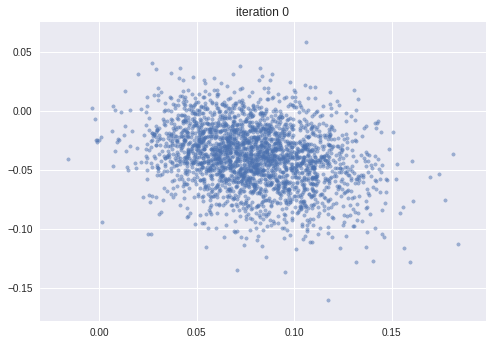

 10%|▉         | 999/10000 [00:31<04:20, 34.49it/s]

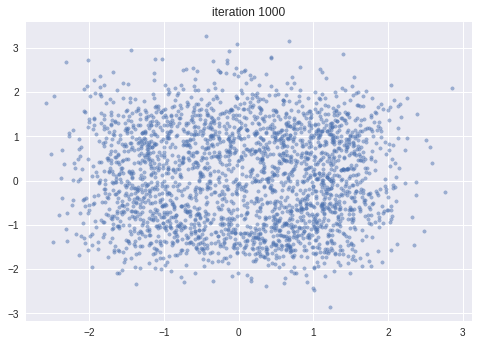

 20%|█▉        | 1999/10000 [01:00<03:51, 34.53it/s]

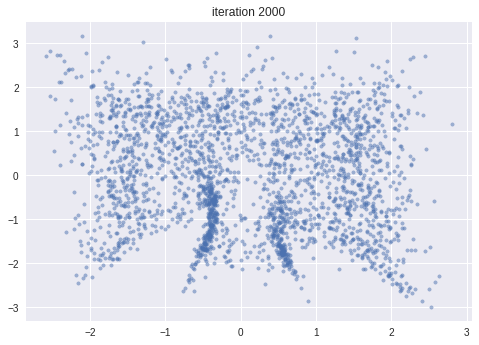

 30%|██▉       | 2999/10000 [01:29<03:21, 34.72it/s]

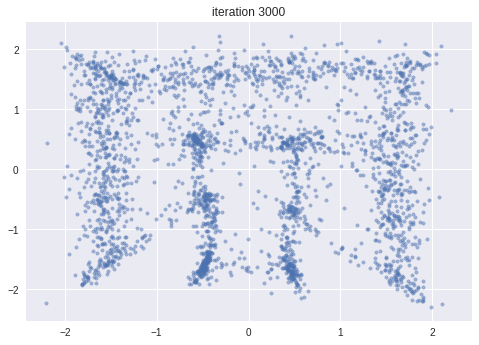

 40%|███▉      | 3999/10000 [01:58<02:50, 35.19it/s]

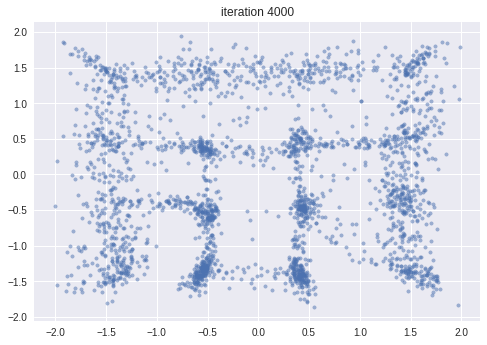

 50%|████▉     | 4999/10000 [02:27<02:21, 35.29it/s]

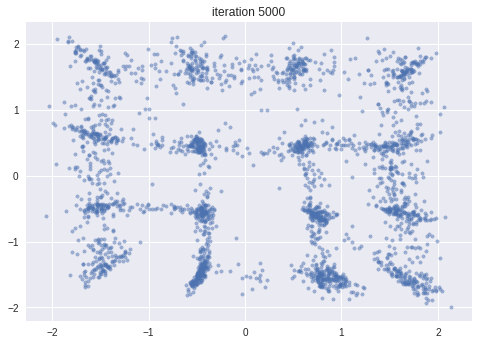

 60%|█████▉    | 5999/10000 [02:55<01:54, 34.80it/s]

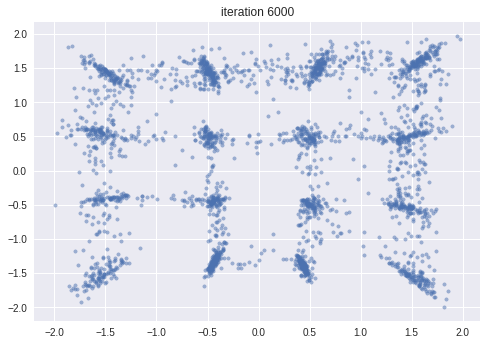

 70%|██████▉   | 6999/10000 [03:25<01:26, 34.65it/s]

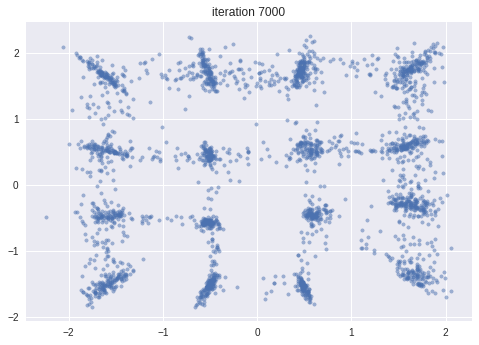

 80%|███████▉  | 7999/10000 [03:53<00:57, 34.90it/s]

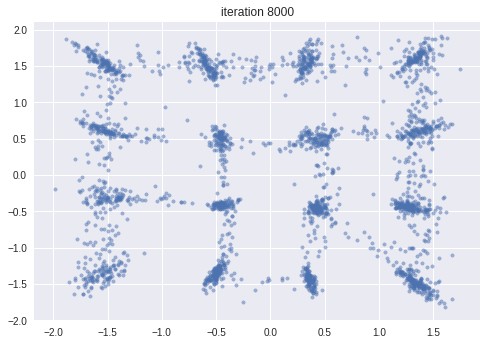

 90%|████████▉ | 8999/10000 [04:22<00:28, 34.67it/s]

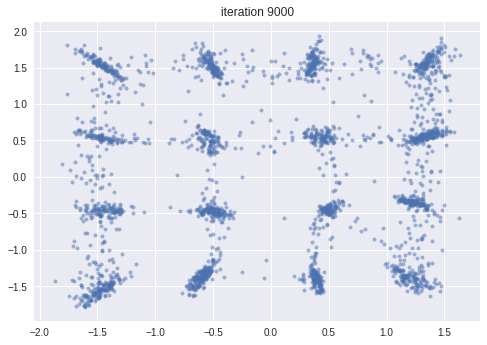

100%|██████████| 10000/10000 [04:52<00:00, 34.24it/s]


In [62]:
learn_mixture_of_gaussians()